In [1]:
import sys
sys.path.append("..") 
from utils import coefs, parameterize, helpers

In [81]:
from scipy.ndimage import map_coordinates
from imageio import imread
d = "/mnt/c/Users/trang.le/Desktop/2D_shape_space/U2OS_2"
img_id = "757_50_D9_1_3"
protein = imread(f"{d}/{img_id}_protein.png")
shape = imread(f"{d}/{img_id}.png")
avg_shape = imread("/mnt/c/Users/trang.le/Desktop/2D_shape_space/shapespace_plots/Avg_cell.jpg")

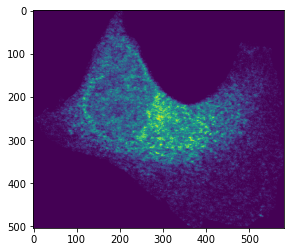

In [82]:
import matplotlib.pyplot as plt
plt.imshow(protein)

In [46]:
protein.shape

(312, 364)

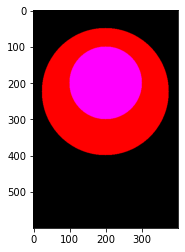

In [47]:
import numpy as np
from skimage.morphology import disk, square, dilation

height, width = 600, 400
#centroid = (, width//2)
target_nu = np.zeros((height, width), dtype=np.uint8)
target_nu[100:301,100:301] = disk(100)
target_cell = np.zeros((height, width), dtype=np.uint8)
target_cell[49:400, 24:375] = disk(175)
#target_cell[50:351,50:351] = disk(150)
avg_cell = np.dstack([target_cell, np.zeros((height,width)),target_nu])
plt.imshow(avg_cell)

In [550]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    print(x.shape)
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

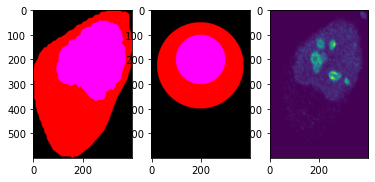

In [51]:
#shape = np.rotate(shape,90)
from skimage.transform import rescale, resize
fig,ax = plt.subplots(1,3)
ax[0].imshow(resize(np.rot90(shape,1), (600,400)))
ax[1].imshow(avg_cell)#elastic_transform(shape,8,0.5))
ax[2].imshow(resize(np.rot90(protein,1), (600,400)))

In [52]:
from skimage.color import rgb2gray
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
# --- Compute the optical flow
results_ = optical_flow_ilk(resize(np.rot90(shape,1), (600,400)), avg_cell, radius=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


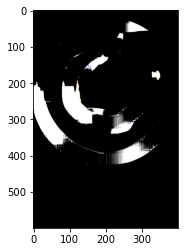

In [53]:
plt.imshow(results_[1,:,:,:])

In [553]:
image0 = rgb2gray(resize(np.rot90(shape,3), (600,400)))
image1 = rgb2gray(avg_cell)

# --- Compute the optical flow
#from cv2 import calcOpticalFlowPyrLK
#results = calcOpticalFlowPyrLK(image0, image1)
v, u = optical_flow_tvl1(image1, image0) # u=dx/dt, v=dy/dt

600 600 (600, 400) 600 400


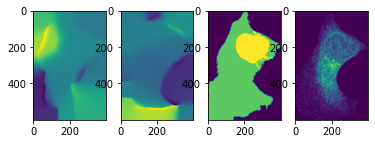

In [554]:
nr, nc = image0.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')
print(len(row_coords), len(col_coords), image0.shape, nr, nc)

image1_warp = warp(image0, np.array([row_coords + u, col_coords + v]),
                   mode='edge')
fig, ax = plt.subplots(1,4)
ax[0].imshow(u)
ax[1].imshow(v)
ax[2].imshow(image1_warp)
ax[3].imshow(resize(np.rot90(protein,3), (600,400)))

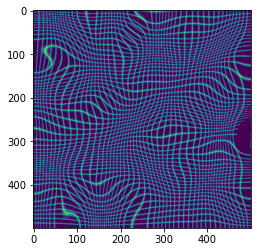

In [51]:
warped = cv.remap(img, xmap, ymap ,cv.INTER_LINEAR)
plt.imshow(warped)

(0.0, 499.0, 0.0, 499.0)

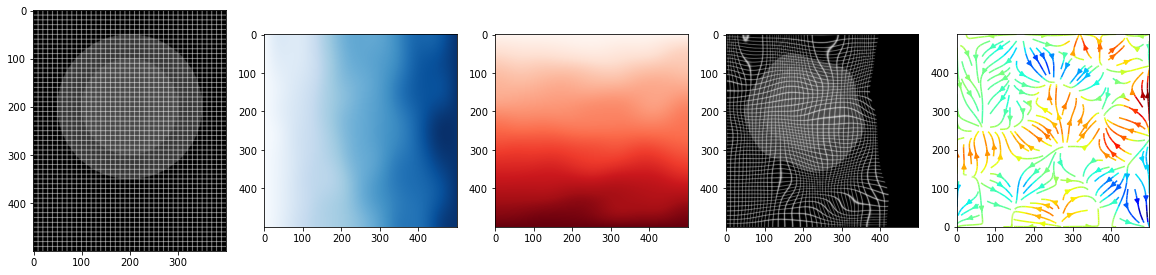

In [299]:
'''
import numpy as np

def bilinear_inverse(p, vertices, numiter=4):
    """
    Compute the inverse of the bilinear map from the unit square
    [(0,0), (1,0), (1,1), (0,1)]
    to the quadrilateral vertices = [p0, p1, p2, p4]

    Parameters:
    ----------
    p: array of shape (2, ...)
        Points on which the inverse transforms are applied.
    vertices: array of shape (4, 2, ...)
        Coordinates of the vertices mapped to the unit square corners
    numiter:
        Number of Newton interations

    Returns:
    --------
    s: array of shape (2, ...)
        Mapped points.

    This is a (more general) python implementation of the matlab implementation 
    suggested in https://stackoverflow.com/a/18332009/1560876
    """

    p = np.asarray(p)
    v = np.asarray(vertices)
    sh = p.shape[1:]
    if v.ndim == 2:
        v = np.expand_dims(v, axis=tuple(range(2, 2 + len(sh))))

    # Start in the center
    s = .5 * np.ones((2,) + sh)
    s0, s1 = s
    for k in range(numiter):
        # Residual
        r = v[0] * (1 - s0) * (1 - s1) + v[1] * s0 * (1 - s1) + v[2] * s0 * s1 + v[3] * (1 - s0) * s1 - p

        # Jacobian
        J11 = -v[0, 0] * (1 - s1) + v[1, 0] * (1 - s1) + v[2, 0] * s1 - v[3, 0] * s1
        J21 = -v[0, 1] * (1 - s1) + v[1, 1] * (1 - s1) + v[2, 1] * s1 - v[3, 1] * s1
        J12 = -v[0, 0] * (1 - s0) - v[1, 0] * s0 + v[2, 0] * s0 + v[3, 0] * (1 - s0)
        J22 = -v[0, 1] * (1 - s0) - v[1, 1] * s0 + v[2, 1] * s0 + v[3, 1] * (1 - s0)

        inv_detJ = 1. / (J11 * J22 - J12 * J21)

        s0 -= inv_detJ * (J22 * r[0] - J12 * r[1])
        s1 -= inv_detJ * (-J21 * r[0] + J11 * r[1])

    return s


def invert_map(xmap, ymap, diagnostics=False):
    """
    Generate the inverse of deformation map defined by (xmap, ymap) using inverse bilinear interpolation.
    """

    # Generate quadrilaterals from mapped grid points.
    quads = np.array([[ymap[:-1, :-1], xmap[:-1, :-1]],
                      [ymap[1:, :-1], xmap[1:, :-1]],
                      [ymap[1:, 1:], xmap[1:, 1:]],
                      [ymap[:-1, 1:], xmap[:-1, 1:]]])

    # Range of indices possibly within each quadrilateral
    x0 = np.floor(quads[:, 1, ...].min(axis=0)).astype(int)
    x1 = np.ceil(quads[:, 1, ...].max(axis=0)).astype(int)
    y0 = np.floor(quads[:, 0, ...].min(axis=0)).astype(int)
    y1 = np.ceil(quads[:, 0, ...].max(axis=0)).astype(int)

    # Quad indices
    i0, j0 = np.indices(x0.shape)

    # Offset of destination map
    x0_offset = x0.min()
    y0_offset = y0.min()

    # Index range in x and y (per quad)
    xN = x1 - x0 + 1
    yN = y1 - y0 + 1

    # Shape of destination array
    sh_dest = (1 + x1.max() - x0_offset, 1 + y1.max() - y0_offset)

    # Coordinates of destination array
    yy_dest, xx_dest = np.indices(sh_dest)

    xmap1 = np.zeros(sh_dest)
    ymap1 = np.zeros(sh_dest)
    TN = np.zeros(sh_dest, dtype=int)

    # Smallish number to avoid missing point lying on edges
    epsilon = .01

    # Loop through indices possibly within quads
    for ix in range(xN.max()):
        for iy in range(yN.max()):
            # Work only with quads whose bounding box contain indices
            valid = (xN > ix) * (yN > iy)

            # Local points to check
            p = np.array([y0[valid] + ix, x0[valid] + iy])

            # Map the position of the point in the quad
            s = bilinear_inverse(p, quads[:, :, valid])

            # s out of unit square means p out of quad
            # Keep some epsilon around to avoid missing edges
            in_quad = np.all((s > -epsilon) * (s < (1 + epsilon)), axis=0)

            # Add found indices
            ii = p[0, in_quad] - y0_offset
            jj = p[1, in_quad] - x0_offset

            ymap1[ii, jj] += i0[valid][in_quad] + s[0][in_quad]
            xmap1[ii, jj] += j0[valid][in_quad] + s[1][in_quad]

            # Increment count
            TN[ii, jj] += 1

    ymap1 /= TN + (TN == 0)
    xmap1 /= TN + (TN == 0)

    if diagnostics:
        diag = {'x_offset': x0_offset,
                'y_offset': y0_offset,
                'mask': TN > 0}
        return xmap1, ymap1, diag
    else:
        return xmap1, ymap1

'''
import cv2 as cv
from scipy import ndimage as ndi

# Simulate deformation field
N = 500
sh = (N, N)
t = np.random.normal(size=sh)
dx = ndi.gaussian_filter(t, 40, order=(0,1))
dy = ndi.gaussian_filter(t, 40, order=(1,0))
dx *= 30/dx.max()
dy *= 30/dy.max()

# Test image
img = image1[:500,:500]#np.zeros(sh)
img[::10, :] = 1
img[:, ::10] = 1
img = ndi.gaussian_filter(img, 0.5)

# Apply forward mapping
yy, xx = np.indices(sh)
xmap = (xx-dx).astype(np.float32)
ymap = (yy-dy).astype(np.float32)
warped = cv.remap(img, xmap, ymap ,cv.INTER_LINEAR)
fig, ax = plt.subplots(1,5, figsize=(20,5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(xmap, cmap='Blues')
ax[2].imshow(ymap, cmap='Reds')
ax[3].imshow(warped, cmap='gray')
color = dy
lw = 1
ax[4].streamplot(xx,yy,dx, dy, color=color, density=1., cmap='jet', arrowsize=1)
ax[4].axis("scaled")

In [55]:
ymap.max()

499.2336

# Displacement field

- optical flow from cv2
- dx, dy from defined places/landmarks (the interpolated rings points)

In [555]:
# Simulate deformation field, going from round (shapemode) to deformed (original shape) image
sh = (600, 400)
t = np.random.normal(size=sh)
dx = np.zeros(sh)
dy = np.zeros(sh)
dxy_anchor_points = pts2 - pts1

for dxy, standard_coords in zip(dxy_anchor_points, np.round(pts2)):
    dx[int(standard_coords[0]),int(standard_coords[1])] = dxy[0] 
    dy[int(standard_coords[0]),int(standard_coords[1])] = dxy[1]

IndexError: index 600 is out of bounds for axis 0 with size 600

In [62]:
grid_y.astype('float32')

array([[  0.,   1.,   2., ..., 397., 398., 399.],
       [  0.,   1.,   2., ..., 397., 398., 399.],
       [  0.,   1.,   2., ..., 397., 398., 399.],
       ...,
       [  0.,   1.,   2., ..., 397., 398., 399.],
       [  0.,   1.,   2., ..., 397., 398., 399.],
       [  0.,   1.,   2., ..., 397., 398., 399.]], dtype=float32)

In [36]:
pts2.shape, dxy_anchor_points[:,0].shape

((89, 2), (89,))

In [365]:
from scipy.interpolate import griddata
# separate displacement field calculation for x and y
grid_dx = griddata(pts2, dxy_anchor_points[:,0], (grid_x, grid_y), method='cubic')
grid_dy = griddata(pts2, dxy_anchor_points[:,1], (grid_x, grid_y), method='cubic')

In [111]:
from scipy.signal import convolve2d

(-0.5, 420.025, 630.025, -0.5)

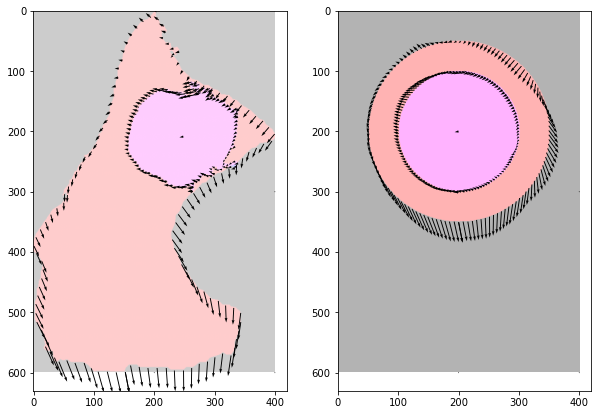

In [364]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
#plt.imshow(ori_shape)
ax[0].imshow(ori_shape, alpha=0.2)
ax[0].quiver(pts1[:,1], pts1[:,0], dxy_anchor_points[:,1], dxy_anchor_points[:,0], scale_units='xy')
ax[0].axis("scaled")
ax[1].imshow(avg_cell, alpha=0.3)
ax[1].quiver(pts2[:,1], pts2[:,0], dxy_anchor_points[:,1], dxy_anchor_points[:,0], scale_units='xy')
ax[1].axis("scaled")

In [211]:
def optical_flow(I1g, I2g, window_size, tau=1e-2):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = window_size/2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade 
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            #b = ... # get b here
            #A = ... # get A here
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            nu = ... # get velocity here
            u[i,j]=nu[0]
            v[i,j]=nu[1]
 
    return (u,v)

In [213]:
u,v = optical_flow(image0, image1, 5, tau=1e-2)

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
u,v optical_flow(I1g, I2g, window_size

In [54]:
warped = cv.remap(resize(np.rot90(protein,1),(600,400)), grid_dy.astype('float32'), grid_dx.astype('float32'), cv.INTER_LINEAR)
warped.shape, warped.dtype

NameError: name 'grid_dy' is not defined

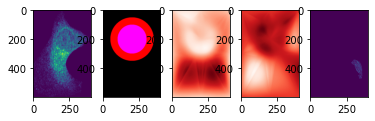

In [149]:
fig, ax = plt.subplots(1,5)
ax[0].imshow(resize(np.rot90(protein,3),(600,400)))
ax[1].imshow(avg_cell)
ax[2].imshow(grid_dx, cmap='Reds')
ax[3].imshow(grid_dy, cmap='Reds')
ax[4].imshow(warped*10)
#ax[5].quiver(grid_x,grid_y, grid_dx, grid_dy)

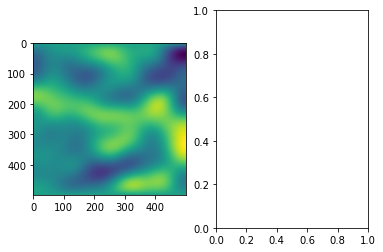

In [449]:
yy, xx = np.indices(sh)
xmap = (xx-dx).astype(np.float32)
ymap = (yy-dy).astype(np.float32)
warped = cv.remap(resize(np.rot90(protein,3),sh), xmap, ymap ,cv.INTER_LINEAR)
fig, ax = plt.subplots(1,2)
ax[0].imshow(xmap)
ax[0].imshow(dy)

# Delaunay triangulation and warpAffine

usually use for face wrapping :( 
Failed because cells just don't have same landmarks at defined places

2001
n_triangles : 163


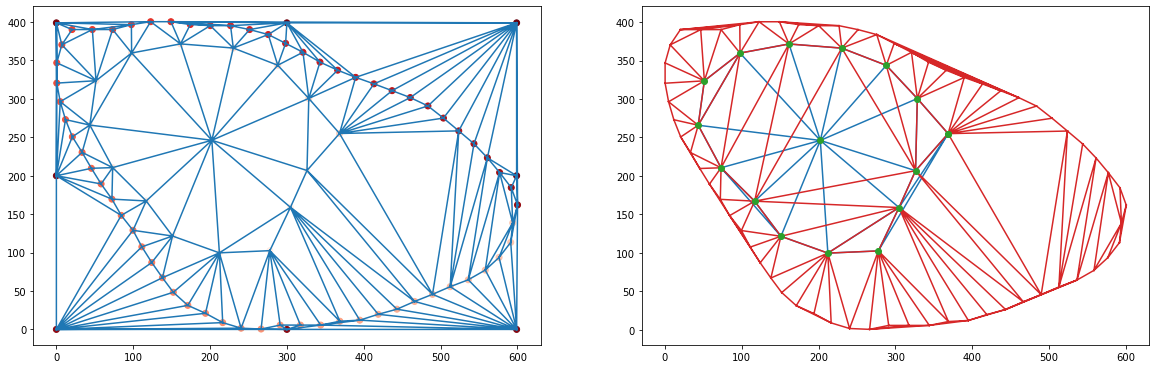

n_triangles : 134
(600, 400, 3) (600, 400, 3)


In [56]:
import cv2
from skimage.measure import find_contours, regionprops
from scipy.ndimage import center_of_mass, rotate
from scipy.spatial import Delaunay

(x_max, y_max,_) = avg_cell.shape
border_anchors = [[0,0],[x_max//2,0],[x_max-1,0],[0,y_max//2],[0,y_max-1],[x_max//2,y_max-1],[x_max-1,y_max//2],[x_max-1,y_max-1]]

ori_shape = resize(np.rot90(shape,1), (600,400))

nu_ = ori_shape[:,:,2]
nu = np.zeros((nu_.shape[0]+2, nu_.shape[1]+2))
nu[1:1+nu_.shape[0],1:1+nu_.shape[1]] = nu_
nu_centroid = center_of_mass(nu) 
nu_contour = find_contours(nu_)
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=16)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_ = ori_shape[:,:,0]
cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_
cell_contour = find_contours(cell) 
#plt.scatter(cell_contour[0][:,0], cell_contour[0][:,1])
#plt.axis("scaled")
print(len(cell_contour[0]))
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=64)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])


# triangulate all points
dstTri = Delaunay(pts1).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].triplot(pts1[:,0], pts1[:,1], dstTri)
ax[0].scatter(pts1[:,0], pts1[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# triangulate nucleus and cytoplasm separately
nu_pt = np.vstack([np.array(nu_centroid),nu_contour])
cell_pt = np.vstack([nu_contour,cell_contour])
dstTri = np.vstack([Delaunay(nu_pt).simplices, Delaunay(cell_pt).simplices])
ax[1].triplot(nu_pt[:,0], nu_pt[:,1], Delaunay(nu_pt).simplices)
ax[1].plot(nu_pt[:,0], nu_pt[:,1], 'o')
ax[1].triplot(cell_pt[:,0], cell_pt[:,1], Delaunay(cell_pt).simplices)
ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")


nu_centroid = center_of_mass(avg_cell[:,:,2]) 
nu_contour = find_contours(avg_cell[:,:,2])
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=16)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_contour = find_contours(avg_cell[:,:,0]) 
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=64)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts2 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])

# Delaunay triangulation
# Each triangle is represented as three integers: each value represents a index in to the original points array.
srcTri = Delaunay(pts1).simplices
dstTri = Delaunay(pts2).simplices
print(avg_cell.shape, ori_shape.shape)
#M = transformation_from_points(tri1, tri2)


#warp_mat = cv2.getAffineTransform(srcTri, dstTri)
#dst = cv2.warpAffine(img, M, (cols, rows))
  

In [57]:
srcTri_set = [set(tri) for tri in srcTri]
dstTri_set = [set(tri) for tri in dstTri]
union = [tri in dstTri_set for tri in srcTri_set]
len(union),sum(union)

(163, 77)

n_triangles : 164


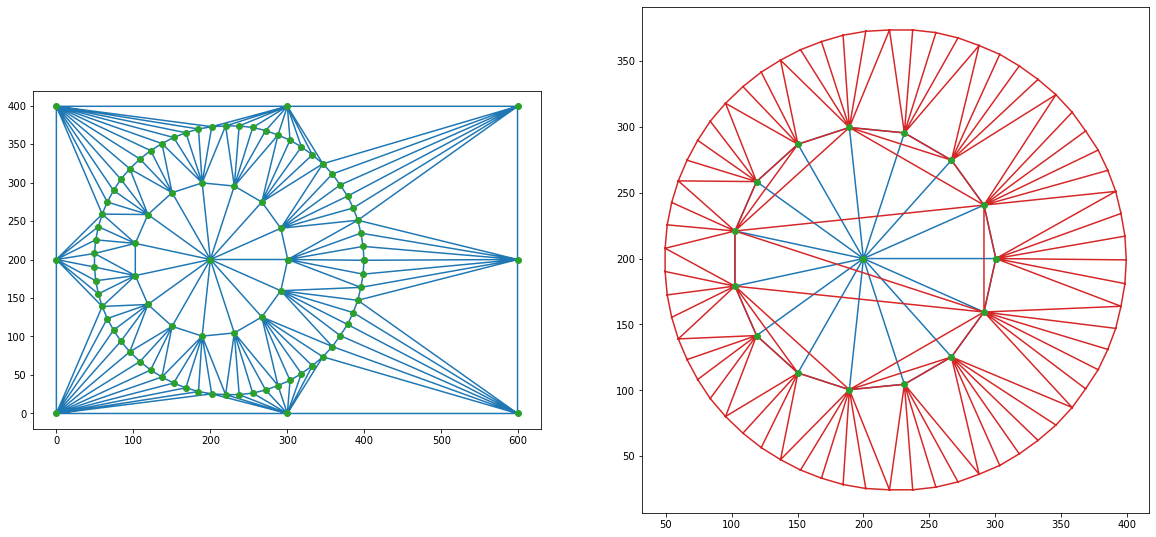

n_triangles : 106


In [58]:
# triangulate all points
dstTri = Delaunay(pts2).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].triplot(pts2[:,0], pts2[:,1], dstTri)
ax[0].plot(pts2[:,0], pts2[:,1], 'o')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# triangulate nucleus and cytoplasm separately
nu_pt = np.vstack([np.array(nu_centroid),nu_contour])
cell_pt = np.vstack([nu_contour,cell_contour])
dstTri = np.vstack([Delaunay(nu_pt).simplices, Delaunay(cell_pt).simplices])
ax[1].triplot(nu_pt[:,0], nu_pt[:,1], Delaunay(nu_pt).simplices)
ax[1].plot(nu_pt[:,0], nu_pt[:,1], 'o')
ax[1].triplot(cell_pt[:,0], cell_pt[:,1], Delaunay(cell_pt).simplices)
ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")

n_triangles : 164
n_triangles : 164


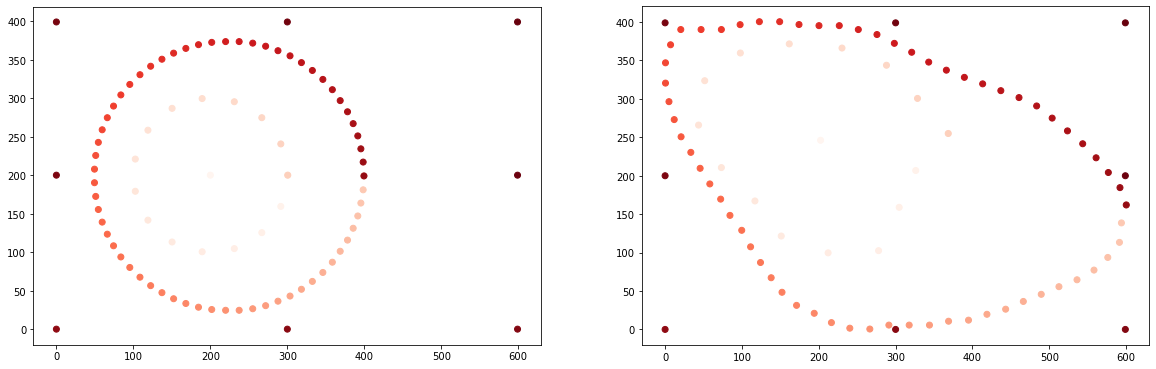

n_triangles : 106


In [59]:
# triangulate all points
c =np.arange(len(dstTri))
dstTri = Delaunay(pts2).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
#ax[0].triplot(pts2[:,0], pts2[:,1], dstTri)
#ax[0].tripcolor(pts2[:,0], pts2[:,1], dstTri, facecolors=c)
ax[0].scatter(pts2[:,0], pts2[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# map the triangle on avg cells to raw cell
#ax[1].triplot(pts1[:,0], pts1[:,1], dstTri)
#ax[1].tripcolor(pts1[:,0], pts1[:,1], srcTri, facecolors=c)
ax[1].scatter(pts1[:,0], pts1[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[1].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")

In [452]:
# we get the Landmark points indexes of each triangle
indexes_triangles = []
for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    index_pt1 = np.where((points == pt1).all(axis=1))
    index_pt1 = extract_index_nparray(index_pt1)
    index_pt2 = np.where((points == pt2).all(axis=1))
    index_pt2 = extract_index_nparray(index_pt2)
    index_pt3 = np.where((points == pt3).all(axis=1))
    index_pt3 = extract_index_nparray(index_pt3)
    if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
        triangle = [index_pt1, index_pt2, index_pt3]
        indexes_triangles.append(triangle)

NameError: name 'triangles' is not defined

In [69]:
tri_f = [[pts1[triangle[0]],pts1[triangle[1]],pts1[triangle[2]]] for triangle in dstTri]
tri_f = (np.round(tri_f)).astype('int')#.transpose(0,2,1)
tri_t = [[pts2[triangle[0]],pts2[triangle[1]],pts2[triangle[2]]] for triangle in srcTri]
tri_t = (np.round(tri_t)).astype('int')#.transpose(0,2,1)


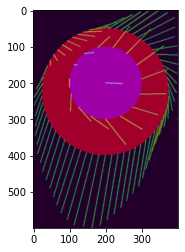

In [60]:
#mat = cv.getAffineTransform(np.array([[0, 145, 0], [0, 128, 200]]).T.astype('float32'), np.array([[59, 52, 0], [0, 28, 251]]).T.astype('float32'))
#np.array([[0, 145, 0], [0, 128, 200]]).astype('float32')
tmp = img.copy()
line = lambda u,v : cv.line(tmp, (u[1], u[0]), (v[1], v[0]), (255,100,100), 2)
for u,v in zip(pts1, pts2):
    line(np.round(u).astype('int'),np.round(v).astype('int'))

plt.imshow(tmp)
plt.imshow(avg_cell, alpha=0.5)

In [126]:
canvas_out = warp_triangles(resize(np.rot90(protein,3), (600,400)), tri_f, tri_t, show_triangles = False, write_canvas = False)
#plt.imshow(draw_triangles(resize(np.rot90(protein,3), (600,400)), tri_f))

(600, 400) 600 600


2001
n_triangles : 131


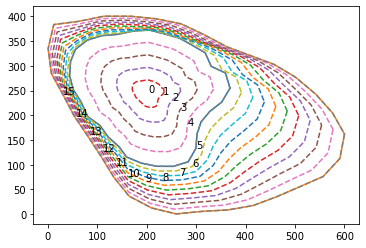

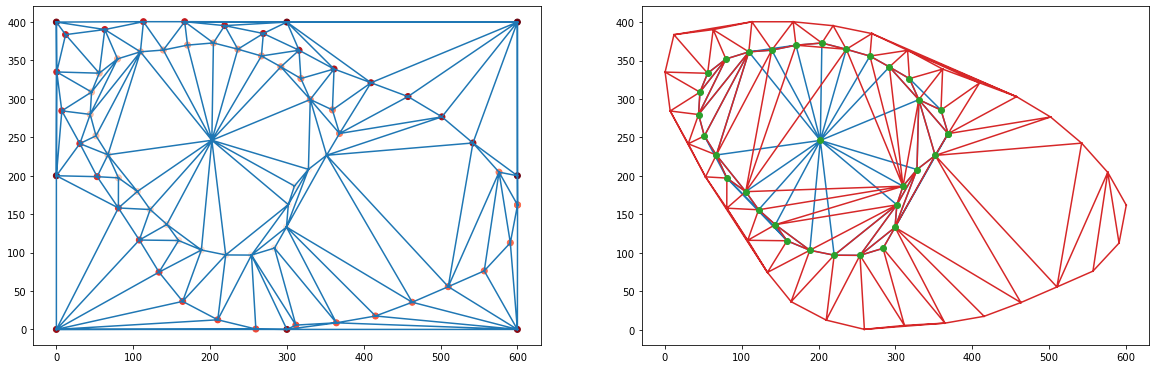

n_triangles : 140
(600, 400, 3) (600, 400, 3)


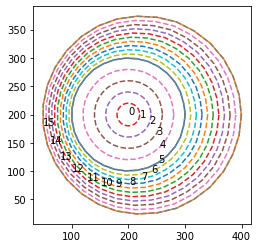

In [61]:
import cv2
from skimage.measure import find_contours, regionprops
from scipy.ndimage import center_of_mass, rotate
from scipy.spatial import Delaunay
from skimage.morphology import convex_hull_image

(x_max, y_max,_) = avg_cell.shape
border_anchors = [[0,0],[x_max//2,0],[x_max,0],[0,y_max//2],[0,y_max],[x_max//2,y_max],[x_max,y_max//2],[x_max,y_max]]

ori_shape = resize(np.rot90(shape,1), (600,400))

nu_ = ori_shape[:,:,2]
nu = np.zeros((nu_.shape[0]+2, nu_.shape[1]+2))
nu[1:1+nu_.shape[0],1:1+nu_.shape[1]] = nu_
nu_centroid = center_of_mass(nu) 
nu_contour = find_contours(nu_)
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=32)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

convex_hull_nu = convex_hull_image(nu_)
convex_hull_nu_contour = find_contours(convex_hull_nu)
x,y = helpers.equidistance(convex_hull_nu_contour[0][:,0], convex_hull_nu_contour[0][:,1], n_points=32)
convex_hull_nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])


cell_ = ori_shape[:,:,0]
cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_
cell_contour = find_contours(cell) 
#plt.scatter(cell_contour[0][:,0], cell_contour[0][:,1])
#plt.axis("scaled")
print(len(cell_contour[0]))
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=32)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1 = np.vstack([np.array(nu_centroid),
                  realign_contour_startpoint(nu_contour),
                  realign_contour_startpoint(cell_contour), border_anchors])

convex_hull_cell = convex_hull_image(cell_)
convex_hull_cell_contour = find_contours(convex_hull_cell)
if len(convex_hull_cell_contour)>1:
    convex_hull_cell_contour = np.vstack(convex_hull_cell_contour)
    convex_hull_cell_contour = realign_contour_startpoint(convex_hull_cell_contour)
    x,y = helpers.equidistance(convex_hull_cell_contour[:,0], convex_hull_cell_contour[:,1], n_points=32)
else:
    x,y = helpers.equidistance(convex_hull_cell_contour[0][:,0], convex_hull_cell_contour[0][:,1], n_points=32)
convex_hull_cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts1_convex = np.vstack([np.array(nu_centroid),
                         realign_contour_startpoint(convex_hull_nu_contour),
                         realign_contour_startpoint(convex_hull_cell_contour), border_anchors])

nuc = np.concatenate([nu_contour[:,0], nu_contour[:,1]])
mem = np.concatenate([cell_contour[:,0], cell_contour[:,1]])
x_,y_ = parameterize.get_coordinates(nuc, mem, nu_centroid, n_isos=[5,10], plot=True)

# triangulate all points
dstTri = Delaunay(pts1).simplices
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].triplot(pts1[:,0], pts1[:,1], dstTri)
ax[0].scatter(pts1[:,0], pts1[:,1],c=np.arange(len(pts1)),cmap='Reds')
ax[0].axis("scaled")
print(f"n_triangles : {len(dstTri)}")

# triangulate nucleus and cytoplasm separately
nu_pt = np.vstack([np.array(nu_centroid),nu_contour])
cell_pt = np.vstack([nu_contour,cell_contour])
dstTri = np.vstack([Delaunay(nu_pt).simplices, Delaunay(cell_pt).simplices])
ax[1].triplot(nu_pt[:,0], nu_pt[:,1], Delaunay(nu_pt).simplices)
ax[1].plot(nu_pt[:,0], nu_pt[:,1], 'o')
ax[1].triplot(cell_pt[:,0], cell_pt[:,1], Delaunay(cell_pt).simplices)
ax[1].axis("scaled")
plt.show()
print(f"n_triangles : {len(Delaunay(nu_pt).simplices)+len(Delaunay(cell_pt).simplices)}")


nu_centroid = center_of_mass(avg_cell[:,:,2]) 
nu_contour = find_contours(avg_cell[:,:,2])
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=32)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_contour = find_contours(avg_cell[:,:,0]) 
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=32)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])
pts2 = np.vstack([np.array(nu_centroid),nu_contour,cell_contour, border_anchors])

nuc = np.concatenate([nu_contour[:,0], nu_contour[:,1]])
mem = np.concatenate([cell_contour[:,0], cell_contour[:,1]])
x_2,y_2 = parameterize.get_coordinates(nuc, mem, nu_centroid, n_isos=[5,10], plot=True)

# Delaunay triangulation
# Each triangle is represented as three integers: each value represents a index in to the original points array.
srcTri = Delaunay(pts1).simplices
dstTri = Delaunay(pts2).simplices
print(avg_cell.shape, ori_shape.shape)
#M = transformation_from_points(tri1, tri2)


#warp_mat = cv2.getAffineTransform(srcTri, dstTri)
#dst = cv2.warpAffine(img, M, (cols, rows))
  

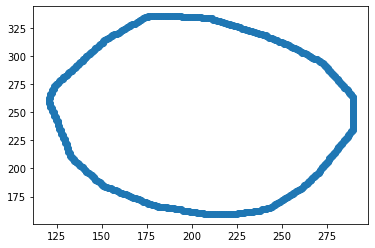

In [89]:
plt.scatter(convex_hull_nu_contour[0][:,0],convex_hull_nu_contour[0][:,1])

In [167]:
#plt.scatter(nu_contour[:,0], nu_contour[:,1])
np.concatenate([nu_contour[:,0], nu_contour[:,1]])

array([299.34549933, 293.86787673, 289.02138432, 277.03836072,
       268.34704002, 249.76923077, 226.58159876, 199.27898273,
       172.40009922, 151.17454064, 134.52030426, 133.96774194,
       138.48973064, 138.32349553, 122.8685881 , 125.57834783,
       127.21160426, 134.01571912, 138.48254051, 147.59971505,
       165.24004954, 175.85217143, 202.26517367, 225.03225806,
       245.03392465, 250.79605669, 259.58938341, 265.82458124,
       266.82008192, 271.54545455, 284.39586131, 299.34549933,
       264.        , 249.32127301, 222.79061509, 205.12280702,
       184.87335581, 167.72499954, 156.75643647, 160.96468657,
       168.57304976, 183.39835374, 204.37470565, 228.53148302,
       251.39647632, 268.87258117, 257.49435107, 275.19993309,
       280.59089014, 293.88479056, 297.72169234, 315.86281224,
       332.26945834, 338.62187301, 336.66666667, 332.2126651 ,
       319.43579128, 330.36672942, 331.11581527, 308.93176763,
       297.17342084, 286.0270945 , 271.77956826, 264.  

# Isopoints and Isobands, plot contourf 

/tmp/ipykernel_353/2089945103.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[0].contour(x, y, Z, 20, colors='b', linewidth=0.5)
/tmp/ipykernel_353/2089945103.py:16: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax[1].contour(x, y, Z2, 20, colors='b', linewidth=0.5)


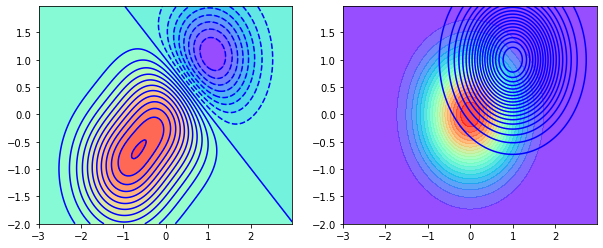

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
x=np.arange(-3, 3, 0.025)
y=np.arange(-2, 2, 0.025)
X, Y=np.meshgrid(x,y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X-1)**2 - (Y-1)**2)
Z3 = np.exp(-(X+1)**2 - (Y+1)**2)
Z = (Z1- Z2 + Z3)*2

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].contourf(x, y, Z, 20, alpha= 0.75,cmap='rainbow')
ax[0].contour(x, y, Z, 20, colors='b', linewidth=0.5)
ax[1].contourf(x, y, Z1, 20, alpha= 0.75,cmap='rainbow')
ax[1].contour(x, y, Z2, 20, colors='b', linewidth=0.5)
plt.show()

In [215]:
x_n, y_n = nu_contour[:,0], nu_contour[:,1]
x_n

array([300.5       , 299.5       , 297.60237007, 295.5       ,
       292.5       , 287.95262431, 282.61472204, 276.569713  ,
       269.81759717, 262.06548135, 254.0204723 , 245.38967682,
       236.46598812, 227.35271363, 217.63220698, 207.49748677,
       197.77698012, 187.22804634, 177.50753969, 168.14230284,
       158.92572092, 150.29492544, 141.95702317, 133.91201413,
       126.45279152, 119.7006757 , 114.36277343, 109.73197795,
       105.80828925, 103.29881411, 101.49644575, 100.5       ,
       100.5       , 101.49644575, 103.29881411, 105.80828925,
       109.73197795, 114.36277343, 119.7006757 , 126.45279152,
       133.91201413, 141.95702317, 150.29492544, 158.92572092,
       168.14230284, 177.50753969, 187.22804634, 197.77698012,
       207.49748677, 217.63220698, 227.35271363, 236.46598812,
       245.38967682, 254.0204723 , 262.06548135, 269.81759717,
       276.569713  , 282.61472204, 287.95262431, 292.5       ,
       295.5       , 297.60237007, 299.5       , 300.5 

In [62]:
npoint = 32
ori_shape = resize(np.rot90(shape,1), (600,400))

nu_ = ori_shape[:,:,2]
nu = np.zeros((nu_.shape[0]+2, nu_.shape[1]+2))
nu[1:1+nu_.shape[0],1:1+nu_.shape[1]] = nu_
nu_centroid = center_of_mass(nu) 
nu_contour = find_contours(nu_)
x,y = helpers.equidistance(nu_contour[0][:,0], nu_contour[0][:,1], n_points=npoint)
nu_contour = np.array([[x[i], y[i]] for i in range(len(x))])

cell_ = ori_shape[:,:,0]
cell = np.zeros((cell_.shape[0]+2, cell_.shape[1]+2))
cell[1:1+cell_.shape[0],1:1+cell_.shape[1]] = cell_
cell_contour = find_contours(cell) 
#plt.scatter(cell_contour[0][:,0], cell_contour[0][:,1])
#plt.axis("scaled")
print(len(cell_contour[0]))
x,y = helpers.equidistance(cell_contour[0][:,0], cell_contour[0][:,1], n_points=npoint)
cell_contour = np.array([[x[i], y[i]] for i in range(len(x))])

2001


IndexError: index 600 is out of bounds for axis 0 with size 600

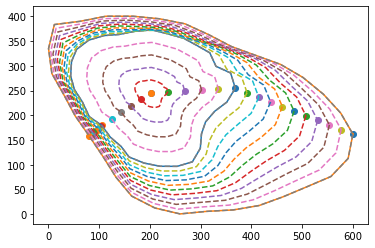

In [63]:
from scipy.interpolate import interp1d, BSpline

x_n, y_n = nu_contour[:,0], nu_contour[:,1]
x_c, y_c = cell_contour[:,0], cell_contour[:,1]
n_isos = [5,10]
iso_values = [0.0] + n_isos
iso_values = np.cumsum(iso_values)
iso_values = iso_values / iso_values[-1]

x = np.c_[np.full_like(x_n, nu_centroid[0]), x_n, x_c]
y = np.c_[np.full_like(y_n, nu_centroid[1]), y_n, y_c]

# Create x and y interpolator
x_interpolator = interp1d(iso_values, x, kind='slinear')
y_interpolator = interp1d(iso_values, y, kind='slinear')
ix_list = []
iy_list = []
z = np.zeros_like(nu_)
if True:
    plt.plot(x_n, y_n)
    plt.plot(x_c, y_c)
    for i, iso_value in enumerate(np.linspace(0.0, 1.0, 1 + np.sum(n_isos))):
        # Get coeffs at given fixed point
        ix = x_interpolator(iso_value)
        iy = y_interpolator(iso_value)
        plt.plot(ix,iy, "--")
        plt.scatter(ix[0],iy[0])
        plt.scatter(ix[13],iy[13])
        #plt.text(ix[i], iy[i], str(i))
        ix_list += [ix]
        iy_list += [iy]
        for ix_, iy_ in zip(ix,iy):
            z[np.floor(ix_).astype('int'),np.floor(iy_).astype('int')] = 100-i*2 
    plt.axis("scaled")
else:
    for i, iso_value in enumerate(np.linspace(0.0, 1.0, 1 + np.sum(n_isos))):
        # Get coeffs at given fixed point
        ix = x_interpolator(iso_value)
        iy = y_interpolator(iso_value)    
        ix_list += [ix]
        iy_list += [iy]

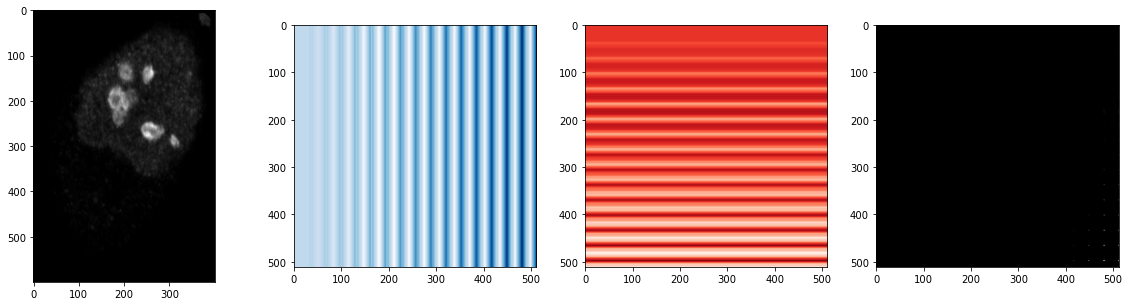

In [64]:
# Irregular grid 1: 
xx1, yy1 = np.meshgrid(x_, y_)
# Irregular grid 2: 
xx2, yy2 = np.meshgrid(x_2, y_2)
xmap = (xx1-xx2).astype(np.float32)
ymap = (yy1-yy2).astype(np.float32)

import cv2 as cv
img = resize(np.rot90(protein,1), (600,400))
warped = cv.remap(img, xmap, ymap ,cv.INTER_LINEAR)
fig, ax = plt.subplots(1,4, figsize=(20,5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(xmap, cmap='Blues')
ax[2].imshow(ymap, cmap='Reds')
ax[3].imshow(warped, cmap='gray')

(-0.5, 629.121618852459, 599.5, -0.5)

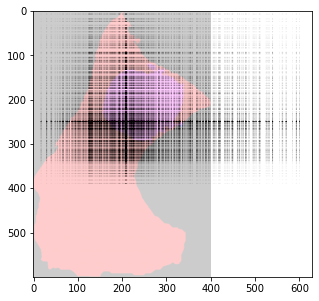

In [22]:
plt.figure(figsize=(5,5))
plt.imshow(ori_shape, alpha=0.2)
plt.quiver(x_, y_, xmap, ymap, scale_units='xy', alpha=0.1)
plt.axis("scaled")

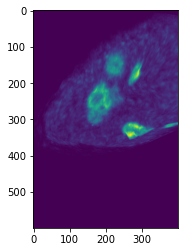

In [66]:
from skimage.transform import PiecewiseAffineTransform, warp

src = np.dstack([np.array(x_).flat, np.array(y_).flat])[0]
dst = np.dstack([np.array(x_2).flat, np.array(y_2).flat])[0]
#dst = np.vstack([np.array(x_2).flat, np.array(y_2).flat]).T

tform = PiecewiseAffineTransform()
tform.estimate(src, dst)
out = warp(img, tform, output_shape=(600,400))
inv = tform.inverse(src)

fig, ax = plt.subplots()
ax.imshow(out)
#ax.scatter(dst[:,0],dst[:,1])
#ax.plot(inv[:, 0], inv[:, 1], '.b')
#ax.axis((0, 600,400, 0))
plt.show()

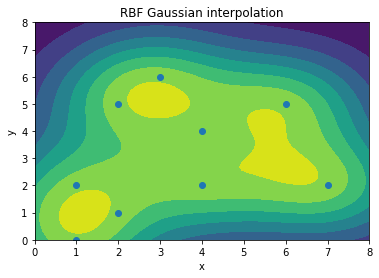

In [24]:
from scipy.interpolate import Rbf  # radial basis functions

# x y arrays
x = [1, 1, 2 ,3, 4, 4, 2, 6, 7]
y = [0, 2, 5, 6, 2, 4, 1, 5, 2]
#x = np.array(ix_list).ravel() #np.hstack([[0,0], x_n, x_c])
#y = np.array(iy_list).ravel() #np.hstack([[0,0], y_n, y_c])
z = [1]*len(x)

#RBF Func
rbf_fun = Rbf(x, y, z, function='gaussian')

x_new = np.linspace(0, 8, 81)
y_new = np.linspace(0, 8, 82)

x_grid, y_grid = np.meshgrid(x_new, y_new)
z_new = rbf_fun(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

plt.contourf(x_new, y_new, z_new)
plt.plot(x, y, 'o');
plt.xlabel('x'); plt.ylabel('y');
plt.title('RBF Gaussian interpolation');

# thin plate splines warp 

Thin-plate splines warped is a widely-used technique in CS, both 2d and 3d https://en.wikipedia.org/wiki/Thin_plate_spline
https://khanhha.github.io/posts/Thin-Plate-Splines-Warping/

1 implementation in Celltool from https://github.com/zpincus/celltool

Original publication: from [Zachary Pincus](https://scholar.google.com/citations?user=D6U4VKwAAAAJ) and [Julie Theriot](https://www.broadinstitute.org/bios/julie-theriot) (Is she at Stanford, MIT and broad, and UWashington simultaneously?)

Lots on bacteria cell movement: https://www.ibiology.org/speakers/julie-theriot/

In [67]:
from utils import image_warp

[[200.         200.        ]
 [300.5        200.        ]
 [297.5        179.80448495]] [[   0.         -100.5         -97.5        ... -184.69708838
  -195.5        -199.5       ]
 [ 100.5           0.            3.         ...  -84.19708838
   -95.          -99.        ]
 [  97.5          -3.            0.         ...  -87.19708838
   -98.         -102.        ]
 ...
 [ 184.69708838   84.19708838   87.19708838 ...    0.
   -10.80291162  -14.80291162]
 [ 195.5          95.           98.         ...   10.80291162
     0.           -4.        ]
 [ 199.5          99.          102.         ...   14.80291162
     4.            0.        ]] [[  0.           0.          20.19551505 ... -67.80291162 -34.81038494
    1.        ]
 [  0.           0.          20.19551505 ... -67.80291162 -34.81038494
    1.        ]
 [-20.19551505 -20.19551505   0.         ... -87.99842667 -55.00589999
  -19.19551505]
 ...
 [ 67.80291162  67.80291162  87.99842667 ...   0.          32.99252668
   68.80291162]
 [ 

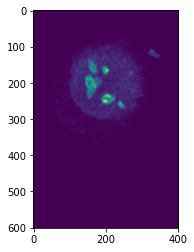

In [68]:
#warped = image_warp.warp_images(pts1, pts2, img, (0, 0, 600, 400), interpolation_order = 1, approximate_grid=2)
midpoint = (pts1 + pts2) /2
t = image_warp._make_inverse_warp(pts1[:-8], pts2[:-8], (0, 0, 600,400), approximate_grid=2)
warped = cv.remap(img, t[1].astype('float32'), t[0].astype('float32'),cv.INTER_LINEAR)
plt.imshow(warped)

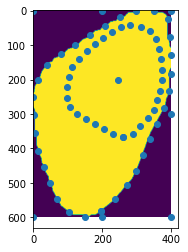

In [69]:
plt.imshow(cell_)
plt.scatter(pts1_convex[:,1],pts1_convex[:,0])

In [100]:
convex_hull_cell_contour = find_contours(convex_hull_image(cell_))

In [26]:
from utils.helpers import equidistance, find_nearest, find_centroid
def realign_contour_startpoint(xy):
    centroid = find_centroid(xy)
    x = np.array([p[0] for p in xy])
    y = np.array([p[1] for p in xy])
    _, val = find_nearest(y[np.where(x > centroid[0])], centroid[1])
    if len(np.where(y == val)[0]) > 1:
        largest_x = x.min()
        current_idx = None
        for idx in np.where(y == val)[0]:
            if x[idx] > largest_x:
                largest_x = x[idx]
                current_idx = idx
        idx = current_idx
    else:
        idx = np.where(y == val)[0][0]

    xy = np.concatenate((xy, xy))[idx : idx + len(xy)]
    return xy

Text(0.5, 1.0, 'landmark arrows')

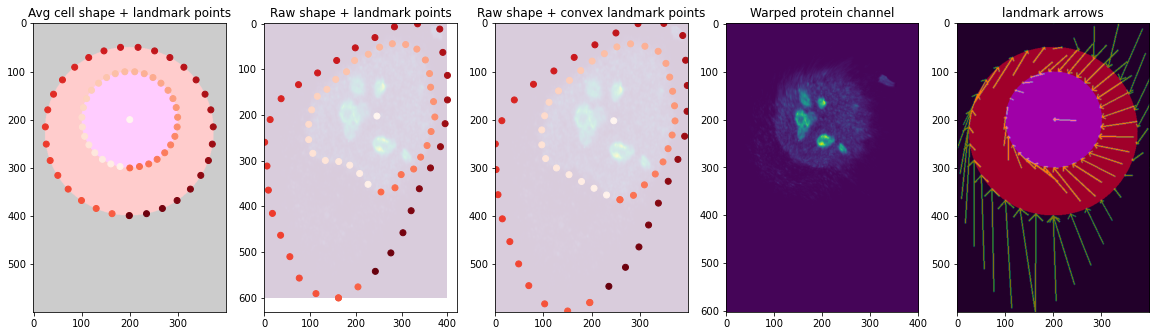

In [70]:
from scipy.ndimage import map_coordinates
warped = map_coordinates(img, t, order=2) 
fig, ax = plt.subplots(1,5, figsize=(20,50))
ax[0].imshow(avg_cell, alpha=0.2)
ax[0].scatter(pts2[:-8][:,1], pts2[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[0].set_title('Avg cell shape + landmark points')
ax[1].imshow(img, alpha=0.2)
ax[1].scatter(pts1[:-8][:,1], pts1[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[1].set_title('Raw shape + landmark points')
ax[2].imshow(img, alpha=0.2)
ax[2].scatter(pts1_convex[:-8][:,1], pts1_convex[:-8][:,0], c=np.arange(len(pts2)-8),cmap='Reds')
ax[2].set_title('Raw shape + convex landmark points')
ax[3].imshow(warped)
ax[3].set_title('Warped protein channel')

tmp = img.copy()
line = lambda u,v : cv.arrowedLine(tmp, (u[1], u[0]), (v[1], v[0]), (255,100,100), 2)
for u,v in zip(pts1, pts2):
    line(np.round(u).astype('int'),np.round(v).astype('int'))

ax[4].imshow(tmp)
ax[4].imshow(avg_cell, alpha=0.5)
ax[4].set_title('landmark arrows')


In [ ]:
xy = pts1_convex[]
    centroid = find_centroid(xy)
    x = np.array([p[0] for p in xy])
    y = np.array([p[1] for p in xy])
    _, val = find_nearest(y[np.where(x > centroid[0])], centroid[1])
    if len(np.where(y == val)[0]) > 1:
        largest_x = x.min()
        current_idx = None
        for idx in np.where(y == val)[0]:
            if x[idx] > largest_x:
                largest_x = x[idx]
                current_idx = idx
        idx = current_idx
    else:
        idx = np.where(y == val)[0][0]

    x = np.concatenate((x, x))[idx : idx + len(xy)]
    y = np.concatenate((y, y))[idx : idx + len(xy)]

## Let's just warp the segmentation mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


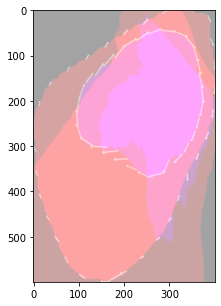

In [71]:
warped = cv.remap(ori_shape, transform1[1].astype('float32'), transform1[0].astype('float32'),cv.INTER_CUBIC)

tmp = ori_shape.copy()
line = lambda u,v : cv.arrowedLine(tmp, (u[1], u[0]), (v[1], v[0]), (255,100,100), 2)
for u,v in zip(pts1, pts1_convex):
    line(np.round(u).astype('int'),np.round(v).astype('int'))

plt.figure(figsize=(5,5))
plt.imshow(warped, alpha=0.2)
plt.imshow(tmp, alpha=0.2)

## intermediate warped shapes

[[201.17375379 223.08238025]
 [334.50584226 227.5       ]
 [324.59411801 203.23255934]] [[   0.         -133.33208847 -123.42036422 ... -219.982884
  -247.46766869 -269.64369224]
 [ 133.33208847    0.            9.91172425 ...  -86.65079553
  -114.13558022 -136.31160377]
 [ 123.42036422   -9.91172425    0.         ...  -96.56251978
  -124.04730446 -146.22332802]
 ...
 [ 219.982884     86.65079553   96.56251978 ...    0.
   -27.48478469  -49.66080824]
 [ 247.46766869  114.13558022  124.04730446 ...   27.48478469
     0.          -22.17602355]
 [ 269.64369224  136.31160377  146.22332802 ...   49.66080824
    22.17602355    0.        ]] [[  0.          -4.41761975  19.84982091 ... -62.34978879 -32.64414216
    2.25661724]
 [  4.41761975   0.          24.26744066 ... -57.93216904 -28.22652241
    6.67423699]
 [-19.84982091 -24.26744066   0.         ... -82.19960969 -52.49396307
  -17.59320366]
 ...
 [ 62.34978879  57.93216904  82.19960969 ...   0.          29.70564662
   64.60640603]
 [ 32

Text(0.5, 1.0, 'average shape')

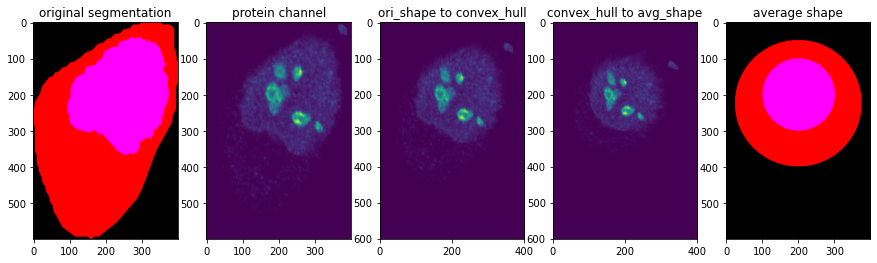

In [80]:
#warped = image_warp.warp_images(pts1, pts2, img, (0, 0, 600, 400), interpolation_order = 1, approximate_grid=2)
midpoint = (pts1 + pts2) /2
transform1 = image_warp._make_inverse_warp(pts1[:-8], midpoint[:-8], (0, 0, 600,400), approximate_grid=4)
transform2 = image_warp._make_inverse_warp(midpoint[:-8], pts2[:-8], (0, 0, 600,400), approximate_grid=4)
warped1 = cv.remap(img, transform1[1].astype('float32'), transform1[0].astype('float32'),cv.INTER_LINEAR)
warped = cv.remap(warped1, transform2[1].astype('float32'), transform2[0].astype('float32'),cv.INTER_LINEAR)
fig, ax = plt.subplots(1,5, figsize=(15,30))
ax[0].imshow(ori_shape)
ax[0].set_title('original segmentation')
ax[1].imshow(img)
ax[1].set_title('protein channel')
ax[2].imshow(warped1)
ax[2].set_title('ori_shape to convex_hull')
ax[3].imshow(warped)
ax[3].set_title('convex_hull to avg_shape')
ax[4].imshow(avg_cell)
ax[4].set_title('average shape')

[[202.34750758 246.16476049]
 [356.70311176 231.20311176]
 [342.66358283 205.16358283]] [[   0.         -154.35560418 -140.31607526 ... -262.31563181
  -304.62482757 -344.19932017]
 [ 154.35560418    0.           14.03952893 ... -107.96002762
  -150.26922338 -189.84371598]
 [ 140.31607526  -14.03952893    0.         ... -121.99955655
  -164.30875231 -203.88324491]
 ...
 [ 262.31563181  107.96002762  121.99955655 ...    0.
   -42.30919576  -81.88368836]
 [ 304.62482757  150.26922338  164.30875231 ...   42.30919576
     0.          -39.5744926 ]
 [ 344.19932017  189.84371598  203.88324491 ...   81.88368836
    39.5744926     0.        ]] [[  0.          14.96164873  41.00117766 ... -52.33523951 -24.36290436
   10.21158824]
 [-14.96164873   0.          26.03952893 ... -67.29688824 -39.3245531
   -4.7500605 ]
 [-41.00117766 -26.03952893   0.         ... -93.33641717 -65.36408202
  -30.78958942]
 ...
 [ 52.33523951  67.29688824  93.33641717 ...   0.          27.97233514
   62.54682774]
 [ 2

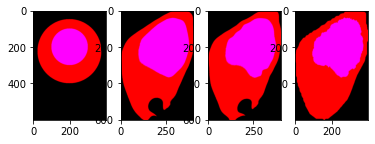

In [73]:
#warped = image_warp.warp_images(pts1, pts2, img, (0, 0, 600, 400), interpolation_order = 1, approximate_grid=2)
midpoint = pts1_convex
transform1 = image_warp._make_inverse_warp(pts2[:-8], midpoint[:-8], (0, 0, 600,400), approximate_grid=2)
transform2 = image_warp._make_inverse_warp(midpoint[:-8], pts1[:-8], (0, 0, 600,400), approximate_grid=2)
warped1 = cv.remap(avg_cell, transform1[1].astype('float32'), transform1[0].astype('float32'), cv.INTER_LINEAR)
warped = cv.remap(warped1, transform2[1].astype('float32'), transform2[0].astype('float32'), cv.INTER_LINEAR)
fig, ax = plt.subplots(1,4)
ax[0].imshow(avg_cell)
ax[1].imshow(warped1)
ax[2].imshow(warped)
ax[3].imshow(ori_shape)

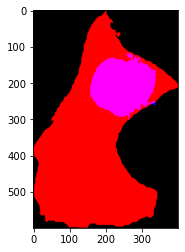

In [43]:
plt.imshow(ori_shape)